In [3]:
import win32com.client
import os
import numpy as np
import time
from os import getcwd
from os.path import join, dirname, exists
from math import pi, sqrt
from scipy.io import loadmat
import re
import matplotlib.pyplot as plt
# # path='D:/KangDH/Optislang_Motorcad/IPM_HDEV_2/MCAD/HDEV_Thesis2/DutyCycleData/'
# # ext_Duty_Cycle='OP1_temp_rise'
# # ext_Duty_Cycle_full=join(path,ext_Duty_Cycle)+'.dat'
# # ext_Duty_Cycle_full

# # power_filename=ext_Duty_Cycle+'_power.csv'
# # power_filename
# # from MotorCAD_Methods import MotorCAD
mcApp = win32com.client.Dispatch("MotorCAD.AppAutomation")  # Launch Motor-CAD application

# # mc=MotorCAD()

Duty Cycle Coupled Transient 해석 결과로 나오는 mat파일 이름 변경


In [8]:
def fun_rename_matfile_lab_duty(ext_Duty_Cycle):
    ex, motpath=mcApp.GetVariable("CurrentMotFilePath_MotorLAB")
    motpath=re.sub(".mot","",motpath)
    Lab_path=motpath+'/Lab/'
    os.chdir(Lab_path)
    rename_matfile=ext_Duty_Cycle+'_lab_result.mat'
    os.rename('MotorLAB_drivecycledata.mat',rename_matfile)
    return rename_matfile

fun_rename_matfile_lab_duty('OP1_temp_rise')

ext_Duty_Cycle='OP1_temp_rise'

# MotorLAB_drivecycledata




FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다: 'MotorLAB_drivecycledata.mat' -> 'OP1_temp_rise_lab_result.mat'

mat 파일에서 온도에 해당하는 정보 뽑아오기

In [9]:
def fun_load_matfile(ext_Duty_Cycle):
    ex, motpath=mcApp.GetVariable("CurrentMotFilePath_MotorLAB")
    motpath=re.sub(".mot","",motpath)
    Lab_path=motpath+'/Lab/'
    os.chdir(Lab_path)
    rename_matfile=ext_Duty_Cycle+'_lab_result.mat'
    Mat_File_Data=loadmat(rename_matfile)
    Mat_File_Speed=Mat_File_Data['Speed']
    Mat_File_Torque=Mat_File_Data['Shaft_Torque']
    Mat_File_Power=Mat_File_Data['Shaft_Power']
    Mat_File_Torque=Mat_File_Torque.flatten()
    Mat_File_Power=Mat_File_Power.flatten()
    Mat_File_Speed=Mat_File_Speed.flatten()
    return Mat_File_Data

OP1_temp_rise_mat=fun_load_matfile('OP1_temp_rise')


In [18]:
OP1_temp_rise_temp=[OP1_temp_rise_mat.get(key) for key in OP1_temp_rise_mat.keys() if 'Temp' in key]
OP1_temp_rise_time=[OP1_temp_rise_mat.get(key) for key in OP1_temp_rise_mat.keys() if 'Time' in key]

In [17]:
OP1_temp_rise_temp_key=[key for key in OP1_temp_rise_mat.keys() if 'Temp' in key]


In [23]:
OP1_temp_rise_temp_dic=dict(zip(OP1_temp_rise_temp_key,OP1_temp_rise_temp))
key=OP1_temp_rise_temp_dic.keys()
max(OP1_temp_rise_temp_dic.get('Magnet_Temp'))

array([130.])

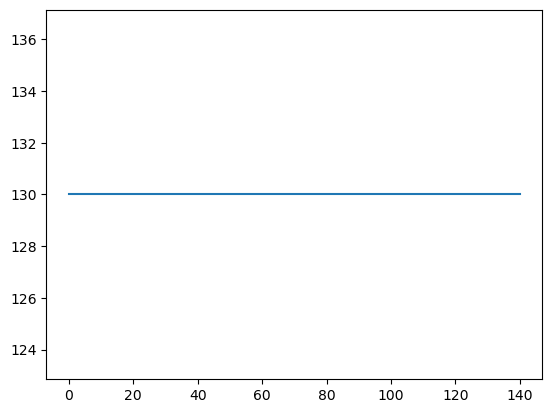

In [113]:
# OP1_temp_rise_time=OP1_temp_rise_time[0]
time=OP1_temp_rise_time[0].ravel().tolist()
temp=OP1_temp_rise_temp[0][1].ravel().tolist()

plt.plot(time,temp)
# plt.plot(OP1_temp_rise_time[0],OP1_temp_rise_temp[0][1])


In [50]:

# Data for plotting
OSL_DESIGN_NAME = 'Design0001'
fig, ax = plt.subplots()
ax.plot(RotorPosition, CoggingTorqueVW)
screenname='CoggingTorqueVW'
ax.set(xlabel='Rotor Position (Mdeg)', ylabel='CoggingTorqueVW [Nm]',
       title='CoggingTorqueVW')
ax.grid()
wdir='Z:/Thesis/Motorcad_Optislang/IPM_HDEV_1/OPD\HDEV_Thesis1.opd/HDEV__Thesis1/'
savedir=join(wdir, 'Design0001' + '/' +  '_Pic_' + screenname )
fig.savefig(join(savedir+'png'))
plt.show()
data_array=[np.transpose(RotorPosition), np.transpose(CoggingTorqueVW)]
io.savemat(join(savedir+'.mat'),{"CoggingTorqueVW":data_array})
# OP1_temp_rise_mat.keys()

Save CSV filed Manually

In [ ]:


def fun_load_temp_rise_2csvfile(lab_transient_fullpath_w_filename):
    mcApp.ExportResults('Transient', power_filename)
    Temp_filename=ext_Duty_Cycle+'_temp.csv'
    power_filename=ext_Duty_Cycle+'_power.csv'

def fun_load_temp_rise_from_MCgraph()
    temp_rise=open(Temp_filename,'r')

